### This notebook takes code from `speculator`: https://github.com/justinalsing/speculator`

In [2]:
%load_ext autoreload
%autoreload 2

In [7]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import astropy.units as u
import kuaizi

In [8]:
kuaizi.set_matplotlib(style='nature', usetex=False, dpi=100)
kuaizi.set_env(project='popsed', name='', data_dir='/scratch/gpfs/jiaxuanl/Data')

'/scratch/gpfs/jiaxuanl/Data/popsed/'

In [27]:
import sys
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import Speculator

In [198]:
speculator = Speculator(n_parameters=2,
                        pca_filename='./train_sed/pca_trained.pkl', 
                        hidden_size=[256, 256, 256])

In [199]:
flag = np.array([ True,  True,  True,  True,  True, False,  True,  True, False])

In [200]:
zero_flag = (np.mean(np.load('./train_sed/log_spec_all.npy'), axis=1) < -30)

In [201]:
log_spec_all = np.load('./train_sed/log_spec_all.npy')[~zero_flag]
pca_coeff = np.load('./train_sed/pca_coeffs.npy')[~zero_flag]
params = np.load('./train_sed/param_all.npy')[:, ~flag][~zero_flag]

In [203]:
speculator.load_data(pca_coeff, params, val_frac=0.1, batch_size=128)
train_ind = speculator.dataloaders['train'].dataset.indices
val_ind = speculator.dataloaders['val'].dataset.indices

In [204]:
# speculator.dataloaders['train'].dataset.indices

In [205]:
# speculator.dataloaders['val'].dataset.indices

In [206]:
%%time
n_ep = [100, 100, 150, 200]
for i, lr in enumerate([2e-3, 1e-3, 5e-4, 3e-4]):
    speculator.train(learning_rate=lr, n_epochs=n_ep[i])

Epoch: 0 - train Loss: 0.0083
Epoch: 0 - val Loss: 0.0811
Epoch: 10 - train Loss: 0.0060
Epoch: 10 - val Loss: 0.0586
Epoch: 20 - train Loss: 0.0048
Epoch: 20 - val Loss: 0.0467
Epoch: 30 - train Loss: 0.0039
Epoch: 30 - val Loss: 0.0379
Epoch: 40 - train Loss: 0.0032
Epoch: 40 - val Loss: 0.0314
Epoch: 50 - train Loss: 0.0026
Epoch: 50 - val Loss: 0.0256
Epoch: 60 - train Loss: 0.0020
Epoch: 60 - val Loss: 0.0199
Epoch: 70 - train Loss: 0.0017
Epoch: 70 - val Loss: 0.0164
Epoch: 80 - train Loss: 0.0014
Epoch: 80 - val Loss: 0.0135
Epoch: 90 - train Loss: 0.0011
Epoch: 90 - val Loss: 0.0110
Epoch: 0 - train Loss: 0.0015
Epoch: 0 - val Loss: 0.0147
Epoch: 10 - train Loss: 0.0009
Epoch: 10 - val Loss: 0.0087
Epoch: 20 - train Loss: 0.0008
Epoch: 20 - val Loss: 0.0081
Epoch: 30 - train Loss: 0.0008
Epoch: 30 - val Loss: 0.0078
Epoch: 40 - train Loss: 0.0007
Epoch: 40 - val Loss: 0.0072
Epoch: 50 - train Loss: 0.0007
Epoch: 50 - val Loss: 0.0067
Epoch: 60 - train Loss: 0.0006
Epoch: 60 - v

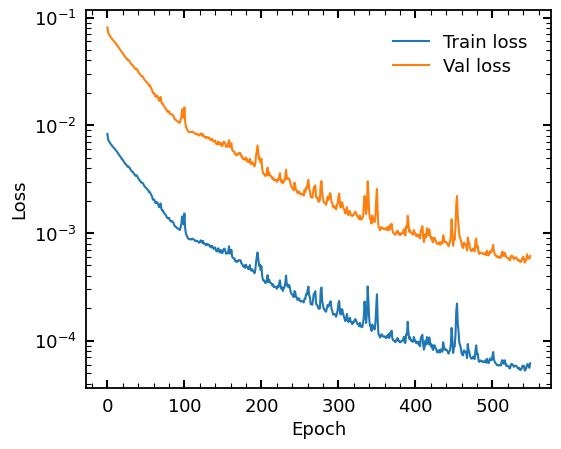

In [208]:
speculator.plot_loss()

In [209]:
_specs = speculator.predict_spec(params)

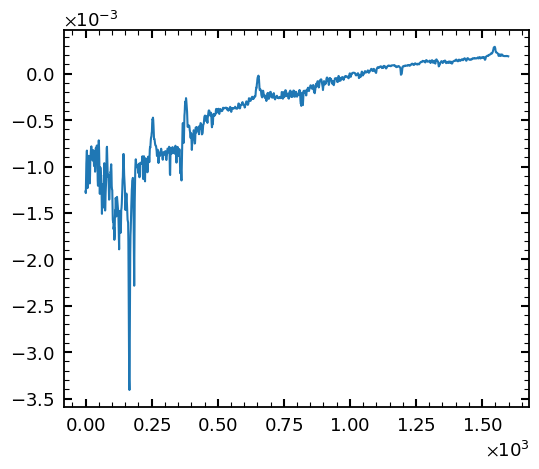

In [210]:
plt.plot(np.median(_specs - log_spec_all, axis=0))

In [220]:
diff = (10**log_spec_all - 10**_specs) / 10**log_spec_all * 100
diff = diff[val_ind]

In [221]:
from scipy.stats import norm

(380.0, 700.0)

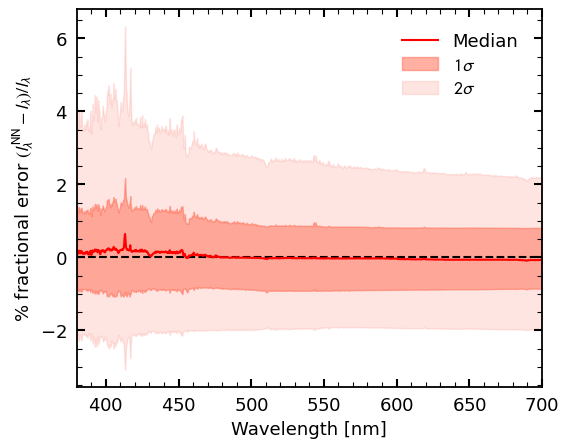

In [222]:
x = np.arange(3800, 7000, 2) / 10
plt.plot(x, np.median(diff, axis=0), color='r', label='Median')
plt.fill_between(x, 
                 np.percentile(diff, (1 - norm.cdf(1)) * 100, axis=0), 
                 np.percentile(diff, norm.cdf(1) * 100, axis=0), alpha=0.5, color='tomato', label=r'$1\sigma$')

plt.fill_between(x, 
                 np.percentile(diff, (1 - norm.cdf(2)) * 100, axis=0), 
                 np.percentile(diff, norm.cdf(2) * 100, axis=0), alpha=0.2, color='salmon', label=r'$2\sigma$')

#plt.ylim(-0.008, 0.008)

plt.ylabel(r'% fractional error $(l_{\lambda}^{\mathrm{NN}} - l_{\lambda})/l_{\lambda}$')
plt.xlabel('Wavelength [nm]')

plt.hlines(0, 380, 700, ls='--', color='k')
plt.legend()

plt.xlim(380, 700)

In [223]:
val_ind[30]

35

Text(0, 0.5, 'Flux Density (normalized to 1 $M_\\odot$)')

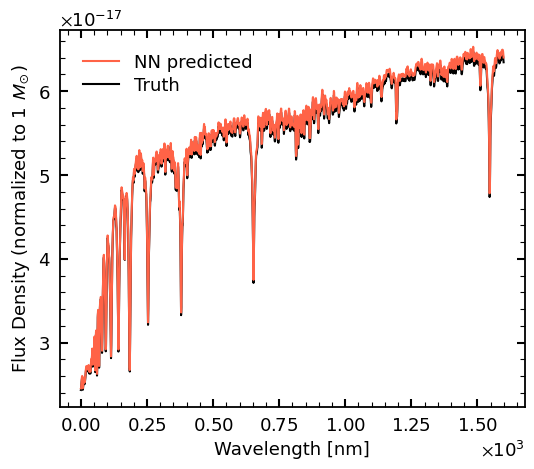

In [224]:
plt.plot(10**_specs[35], label='NN predicted', alpha=1, color='tomato', zorder=3)
plt.plot(10**log_spec_all[35], label='Truth', alpha=1, color='k')

plt.legend()
plt.xlabel('Wavelength [nm]')
plt.ylabel(r'Flux Density (normalized to 1 $M_\odot$)')